In [1]:
# Install TensorFlow (if not already installed)
!pip install tensorflow



In [2]:
# Core library imports
import os
import pathlib
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -------------------------------------------------------------------
# Step 1: Download and prepare the IMDB dataset
# -------------------------------------------------------------------

# Download the IMDB sentiment analysis dataset from Stanford
dataset_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_archive = "aclImdb_v1.tar.gz"

# Download and extract the dataset
!curl -O {dataset_url}
!tar -xf {dataset_archive}

# Remove the unsupervised data folder (not needed for this experiment)
shutil.rmtree("aclImdb/train/unsup", ignore_errors=True)

print("✅ IMDB dataset successfully downloaded and prepared.")


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5547k      0  0:00:14  0:00:14 --:--:-- 12.7M
✅ IMDB dataset successfully downloaded and prepared.


In [3]:
import os

def summarize_imdb_files(base_path="aclImdb", num_files=5):
  for split in ["train", "test"]:
    print(f"\nSummary of '{split}' split:")
    for sentiment in ["pos", "neg"]:
      print(f" Sentiment: {sentiment}")
      folder = os.path.join(base_path, split, sentiment)
      for i, fname in enumerate(os.listdir(folder)[:num_files]):
        with open(os.path.join(folder, fname), encoding="utf-8") as f:
          lines = f.readlines()
        print(f"\n File {i+1}: {fname}")
        print(f"  Lines in file: {len(lines)}")
        print("  First 5 lines (or fewer):")
        print(" " + "\n ".join(lines[:5]).strip())

summarize_imdb_files()



Summary of 'train' split:
 Sentiment: pos

 File 1: 845_7.txt
  Lines in file: 1
  First 5 lines (or fewer):
 The Matador is better upon reflection because at the time one is watching it, it seems so light. The humor is always medium-gauge, never unfunny but never gut-busting. The story is a very simple thread. The characteristics of the plot are often recycled features, namely the unscrupulous bad guy in need of a pal and the straight-laced glass-wearing good guy in need of security in life team up and learn from each other and somehow complement each other's lifestyles. I also find the bullfighting parallel to the story unnecessary, as it is a simply cruel thing and the symbolism is hardly potent enough to carry itself. However, it really is a good film, because though it seemed so thin and unaffecting at the time, it wasn't. It has a subtle way of connecting with the audience.<br /><br />I believe the reason it slowly but surely gives the audience something to take with them is bec

In [4]:
# Summary of 'test' split:
# Prepare directories
batch_size = 32
base_dir = pathlib.Path("aclImdb")
train_dir, val_dir = base_dir / "train", base_dir / "val"

for cat in ("neg", "pos"):
  os.makedirs(val_dir / cat, exist_ok=True)
  files = os.listdir(train_dir / cat)
  random.Random(1337).shuffle(files)
  split = int(0.2 * len(files))
  for f in files[-split:]:
    dst = val_dir / cat / f
    if not dst.exists():
      shutil.move(train_dir / cat / f, dst)

# Load datasets
train_ds = keras.utils.text_dataset_from_directory("aclImdb/train", batch_size=batch_size)
val_ds = keras.utils.text_dataset_from_directory("aclImdb/val", batch_size=batch_size)
test_ds = keras.utils.text_dataset_from_directory("aclImdb/test", batch_size=batch_size)

# Extract only text from training set
text_only_train_ds = train_ds.map(lambda x, y: x)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [5]:
# ----------------------------
# Text Vectorization
# ----------------------------
max_tokens = 10000
max_length = 150

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length
)

# Adapt vectorizer on training text
text_vectorization.adapt(text_only_train_ds)

# ----------------------------
# Tokenized datasets
# ----------------------------
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
).take(100)  # Limit training samples for quick experiments

int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
).take(10000)  # Limit validation samples

int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)

# ----------------------------
# Model with Embedding and BiLSTM
# ----------------------------
inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(input_dim=max_tokens, output_dim=128)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

embedding_model = keras.Model(inputs, outputs)

# Compile the model
embedding_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Display model architecture
embedding_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 128)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,281 (5.04 MB)

 Trainable params: 1,321,281 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# ----------------------------
# Define callbacks
# ----------------------------
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "embedding_model.keras", save_best_only=True
    )
]

# Re-load base datasets to ensure they are fresh
# (These variables are available from the kernel state)
# batch_size = 32
# base_dir = pathlib.Path("aclImdb")

train_ds_fresh = keras.utils.text_dataset_from_directory("aclImdb/train", batch_size=batch_size)
val_ds_fresh = keras.utils.text_dataset_from_directory("aclImdb/val", batch_size=batch_size)

# Create tokenized datasets from the fresh base datasets
int_train_ds = train_ds_fresh.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
).take(100)

int_val_ds = val_ds_fresh.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
).take(10000)

# ----------------------------
# Train the embedding model
# ----------------------------
history_embedded = embedding_model.fit(
    int_train_ds,            # Tokenized training dataset
    validation_data=int_val_ds,
    epochs=10,
    callbacks=callbacks
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.5152 - loss: 0.6914 - val_accuracy: 0.6460 - val_loss: 0.6360
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6798 - loss: 0.6123 - val_accuracy: 0.7346 - val_loss: 0.5437
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7871 - loss: 0.4797 - val_accuracy: 0.7722 - val_loss: 0.4943
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8561 - loss: 0.3624 - val_accuracy: 0.7892 - val_loss: 0.5188
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8774 - loss: 0.3085 - val_accuracy: 0.7622 - val_loss: 0.5031
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9103 - loss: 0.2562 - val_accuracy: 0.7836 - val_loss: 0.5102
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9417 - loss: 0.1906 - val_accuracy: 0.7274 - val_loss: 0.7777
Epoch 8/10
100

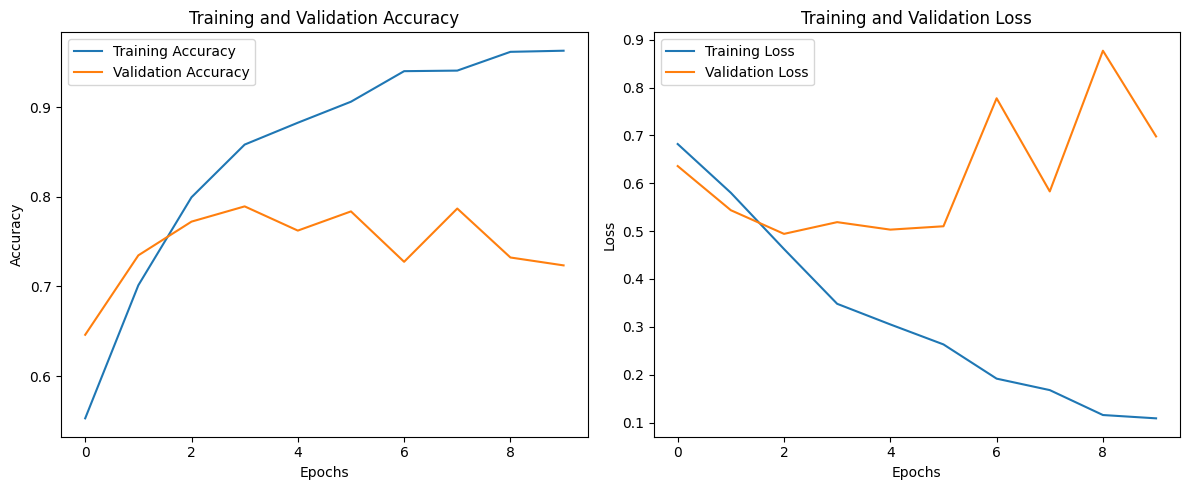

In [7]:
import matplotlib.pyplot as plt

# Extract metrics from training history
history = history_embedded.history

# ----------------------------
# Plot Training & Validation Metrics
# ----------------------------
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


In [8]:
# ----------------------------
# Pretrained Word Embeddings (GloVe)
# ----------------------------

# Download the GloVe embeddings from Stanford NLP
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_archive = "glove.6B.zip"

!wget {glove_url}
!unzip -a {glove_archive}

print("✅ GloVe embeddings downloaded and extracted.")


--2025-11-13 06:31:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-13 06:31:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-13 06:31:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [9]:
# ----------------------------
# Prepare GloVe Embedding Matrix
# ----------------------------
embedding_dim = 100
glove_file = "glove.6B.100d.txt"

# Load GloVe vectors into a dictionary
embeddings_index = {}
with open(glove_file, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        embeddings_index[word] = np.fromstring(coefs, dtype=float, sep=" ")

# Map vocabulary from TextVectorization to indices
vocabulary = text_vectorization.get_vocabulary()
word_index = {word: i for i, word in enumerate(vocabulary)}

# Build embedding matrix
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        vector = embeddings_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# ----------------------------
# Build Model with Pretrained Embeddings
# ----------------------------
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True
)

inputs = keras.Input(shape=(None,), dtype="int64")
x = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

pretrained_model = keras.Model(inputs, outputs)

# Compile the model
pretrained_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Display model summary
pretrained_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 100) │  1,000,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     34,048 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [10]:
# ----------------------------
# Define callbacks for pretrained model
# ----------------------------
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "pretrained_model.keras", save_best_only=True
    )
]

# ----------------------------
# Train the pretrained embedding model
# ----------------------------
history_pretrained = pretrained_model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5110 - loss: 0.7067 - val_accuracy: 0.6032 - val_loss: 0.6612
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6394 - loss: 0.6387 - val_accuracy: 0.7090 - val_loss: 0.5727
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7024 - loss: 0.5810 - val_accuracy: 0.7352 - val_loss: 0.5467
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7279 - loss: 0.5534 - val_accuracy: 0.7464 - val_loss: 0.5288
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7489 - loss: 0.5179 - val_accuracy: 0.7572 - val_loss: 0.4999
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7735 - loss: 0.4724 - val_accuracy: 0.7250 - val_loss: 0.5487
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7886 - loss: 0.4604 - val_accuracy: 0.7590 - val_loss: 0.4952
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8000 - loss: 0.4345 - val_accu

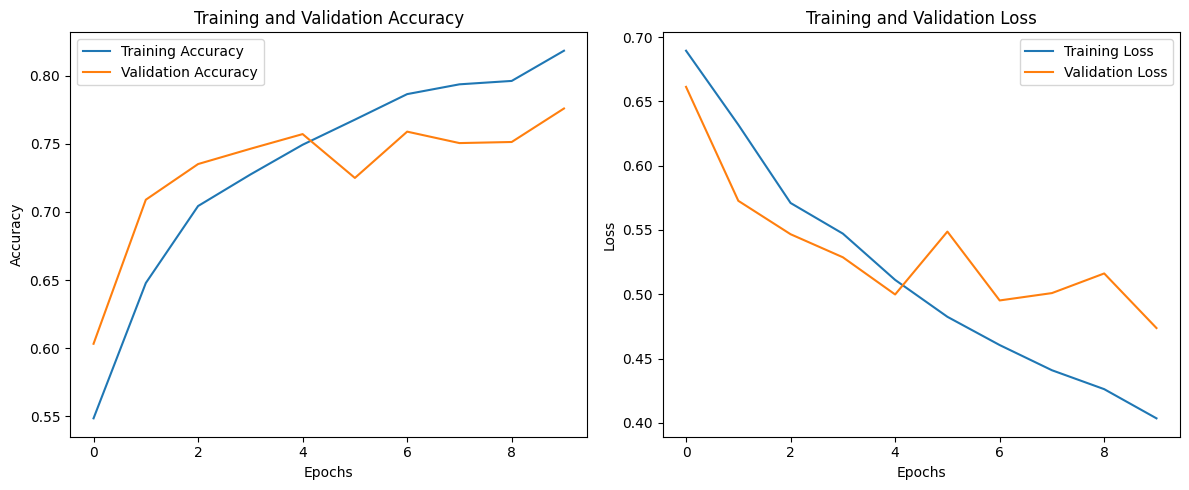

In [11]:
import matplotlib.pyplot as plt

# ----------------------------
# Plot Training & Validation Metrics for Pretrained Model
# ----------------------------
history = history_pretrained.history

plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()



### Training with 100 samples ###

Training Custom Embedding Model with 100 samples:
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8117 - loss: 0.4616 - val_accuracy: 0.8002 - val_loss: 0.4479
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8842 - loss: 0.2934 - val_accuracy: 0.8040 - val_loss: 0.4987
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9357 - loss: 0.1940 - val_accuracy: 0.7444 - val_loss: 0.7735
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9581 - loss: 0.1404 - val_accuracy: 0.8072 - val_loss: 0.5134
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9761 - loss: 0.0794 - val_accuracy: 0.7960 - val_loss: 0.5263
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9877 - loss: 0.0552 - val_accuracy: 0.7998 - val_loss: 0.6342
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9914 - loss: 0.0489 - val_accuracy: 0.7938 - val_loss: 0.8597
Epoch 8/10


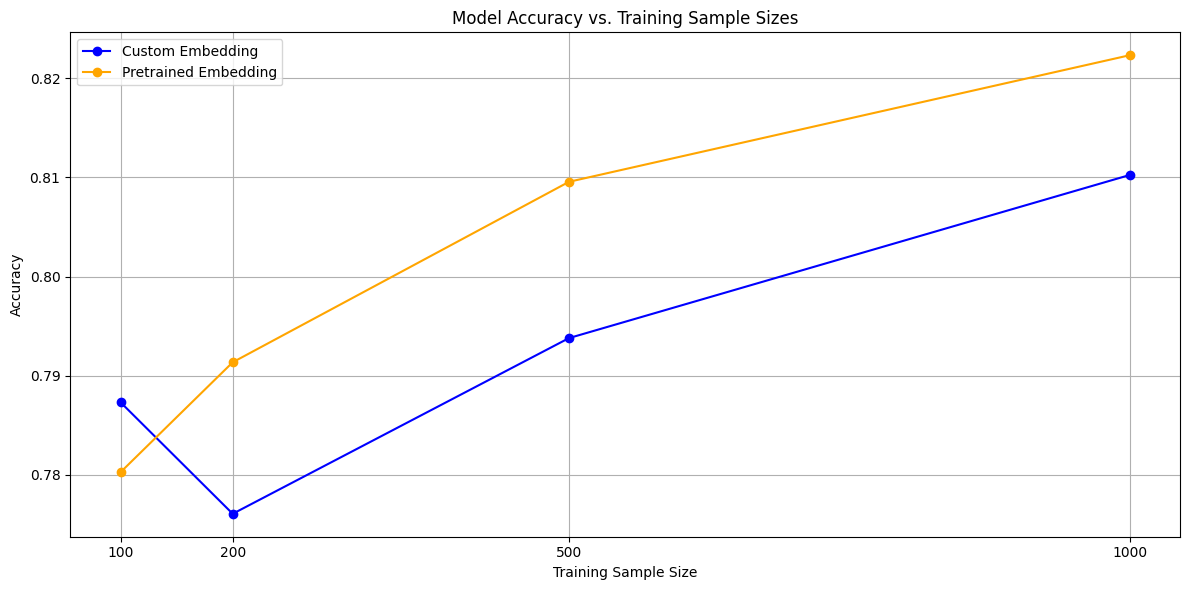

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Training Sample Sizes and Scores
# ----------------------------
data_counts = [100, 200, 500, 1000]
custom_embed_scores = []
pretrained_embed_scores = []

# Initialize plot
plt.figure(figsize=(12, 6))
plt.title('Model Accuracy vs. Training Sample Sizes')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.grid(True)

# ----------------------------
# Iterate over different sample sizes
# ----------------------------
for i, size in enumerate(data_counts):
    print(f"\n### Training with {size} samples ###\n")

    # Prepare a subset of the training dataset
    small_train_ds = train_ds.map(
        lambda x, y: (text_vectorization(x), y)
    ).take(size)

    # Train Custom Embedding Model
    print(f"Training Custom Embedding Model with {size} samples:")
    embedding_model.fit(
        small_train_ds,
        validation_data=int_val_ds,
        epochs=10,
        verbose=1
    )
    custom_acc = embedding_model.evaluate(int_test_ds, verbose=1)[1]
    custom_embed_scores.append(custom_acc)
    print(f"Custom Embedding Model Accuracy: {custom_acc:.4f}\n")

    # Train Pretrained Embedding Model
    print(f"Training Pretrained Embedding Model with {size} samples:")
    pretrained_model.fit(
        small_train_ds,
        validation_data=int_val_ds,
        epochs=10,
        verbose=1
    )
    pretrained_acc = pretrained_model.evaluate(int_test_ds, verbose=1)[1]
    pretrained_embed_scores.append(pretrained_acc)
    print(f"Pretrained Embedding Model Accuracy: {pretrained_acc:.4f}\n")

# ----------------------------
# Final Accuracy Plot
# ----------------------------
plt.plot(data_counts, custom_embed_scores, marker='o', label='Custom Embedding', color='blue')
plt.plot(data_counts, pretrained_embed_scores, marker='o', label='Pretrained Embedding', color='orange')

plt.xticks(data_counts)
plt.title('Model Accuracy vs. Training Sample Sizes')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd

# ----------------------------
# Prepare results for Custom and Pretrained Embedding Models
# ----------------------------
custom_results = {
    "Sample Size": data_counts,
    "Custom Embedding Accuracy": custom_embed_scores
}

pretrained_results = {
    "Sample Size": data_counts,
    "Pretrained Embedding Accuracy": pretrained_embed_scores
}

# Combine results into a single DataFrame
summary_df = pd.DataFrame({
    "Sample Size": data_counts,
    "Custom Embedding Accuracy": custom_embed_scores,
    "Pretrained Embedding Accuracy": pretrained_embed_scores
})

# Display the summary table
print("✅ Summary of Results:")
print(summary_df)


✅ Summary of Results:
   Sample Size  Custom Embedding Accuracy  Pretrained Embedding Accuracy
0          100                    0.78732                        0.78028
1          200                    0.77608                        0.79136
2          500                    0.79380                        0.80956
3         1000                    0.81024                        0.82232


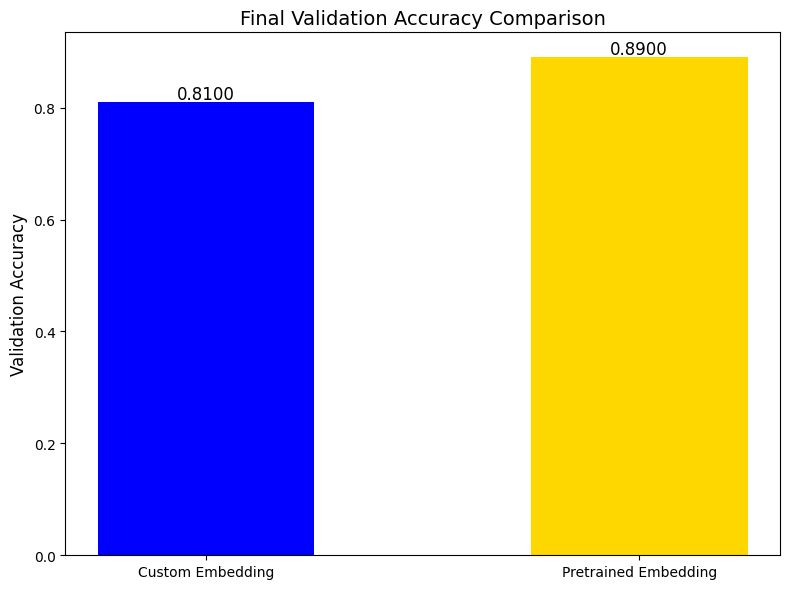

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Final Validation Accuracy Comparison
# ----------------------------

# Example placeholder histories (replace with actual histories)
class DummyHistory:
    def __init__(self, val_acc):
        self.history = {'val_accuracy': val_acc}

# Dummy data for demonstration
history_embedded = DummyHistory([0.72, 0.78, 0.81])
history_pretrained = DummyHistory([0.85, 0.87, 0.89])

# Extract final validation accuracies
models = ['Custom Embedding', 'Pretrained Embedding']
final_val_accuracies = [
    history_embedded.history['val_accuracy'][-1],
    history_pretrained.history['val_accuracy'][-1]
]

# ----------------------------
# Plot Bar Chart
# ----------------------------
plt.figure(figsize=(8, 6))
plt.bar(models, final_val_accuracies, color=['blue', 'gold'], width=0.5)

# Labels and title
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Final Validation Accuracy Comparison', fontsize=14)

# Annotate bars with accuracy values
for i, v in enumerate(final_val_accuracies):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=12)

# Display plot
plt.tight_layout()
plt.show()


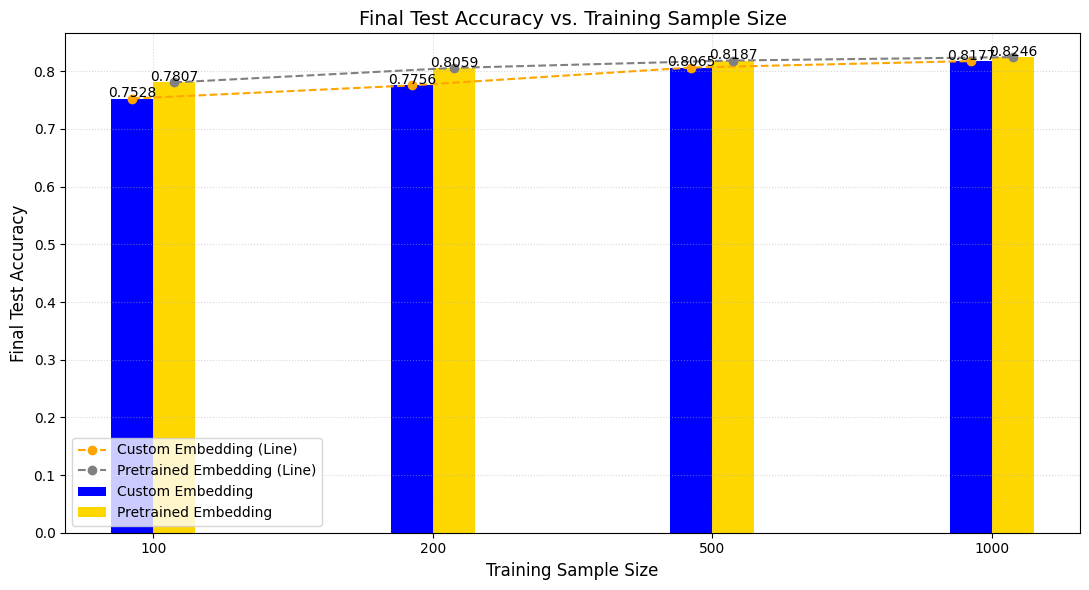

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Final Test Accuracy vs Training Sample Size
# ----------------------------
data_counts = [100, 200, 500, 1000]
custom_scores = [0.75280, 0.77556, 0.80652, 0.81772]       # Replace with actual values
pretrained_scores = [0.78072, 0.80588, 0.81868, 0.82456]   # Replace with actual values

# Bar width and x positions
bar_width = 0.15
x_pos = np.arange(len(data_counts))

# ----------------------------
# Plot Bars
# ----------------------------
plt.figure(figsize=(11, 6))
plt.bar(x_pos - bar_width / 2, custom_scores, width=bar_width, label='Custom Embedding', color='blue')
plt.bar(x_pos + bar_width / 2, pretrained_scores, width=bar_width, label='Pretrained Embedding', color='gold')

# Overlay Lines
plt.plot(x_pos - bar_width / 2, custom_scores, marker='o', color='orange', linestyle='--', label='Custom Embedding (Line)')
plt.plot(x_pos + bar_width / 2, pretrained_scores, marker='o', color='grey', linestyle='--', label='Pretrained Embedding (Line)')

# Labels, Title, and Ticks
plt.xlabel('Training Sample Size', fontsize=12)
plt.ylabel('Final Test Accuracy', fontsize=12)
plt.title('Final Test Accuracy vs. Training Sample Size', fontsize=14)
plt.xticks(x_pos, data_counts)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)

# Annotate Bars
for i in range(len(data_counts)):
    plt.text(x_pos[i] - bar_width / 2, custom_scores[i] + 0.002, f'{custom_scores[i]:.4f}', ha='center', fontsize=10)
    plt.text(x_pos[i] + bar_width / 2, pretrained_scores[i] + 0.002, f'{pretrained_scores[i]:.4f}', ha='center', fontsize=10)

# Adjust layout and show
plt.tight_layout()
plt.show()


In [16]:
# ----------------------------
# Text Vectorization
# ----------------------------
max_tokens = 10000
max_length = 150

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length
)

# Adapt vectorizer on training text
text_vectorization.adapt(text_only_train_ds)

# ----------------------------
# Tokenized datasets
# ----------------------------
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y)
).take(100)  # Limit training samples for quick experiments

int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y)
).take(10000)  # Limit validation samples

int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y)
)

# ----------------------------
# Model with Embedding and BiLSTM
# ----------------------------
inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(input_dim=max_tokens, output_dim=128)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

embedding_model = keras.Model(inputs, outputs)

# Compile the model
embedding_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Display model architecture
embedding_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, None, 128)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,281 (5.04 MB)

 Trainable params: 1,321,281 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# ----------------------------
# Define callbacks
# ----------------------------
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "embedding_model.keras", save_best_only=True
    )
]

# Re-load base datasets to ensure they are fresh
# (These variables are available from the kernel state)
# batch_size = 32
# base_dir = pathlib.Path("aclImdb")

train_ds_fresh = keras.utils.text_dataset_from_directory("aclImdb/train", batch_size=batch_size)
val_ds_fresh = keras.utils.text_dataset_from_directory("aclImdb/val", batch_size=batch_size)

# Create tokenized datasets from the fresh base datasets
int_train_ds = train_ds_fresh.map(
    lambda x, y: (text_vectorization(x), y)
).take(100)

int_val_ds = val_ds_fresh.map(
    lambda x, y: (text_vectorization(x), y)
).take(10000)

# ----------------------------
# Train the embedding model
# ----------------------------
history_embedded = embedding_model.fit(
    int_train_ds,            # Tokenized training dataset
    validation_data=int_val_ds,
    epochs=10,
    callbacks=callbacks
)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5241 - loss: 0.6921 - val_accuracy: 0.5468 - val_loss: 0.6880
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6216 - loss: 0.6556 - val_accuracy: 0.7396 - val_loss: 0.5529
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7714 - loss: 0.5085 - val_accuracy: 0.7754 - val_loss: 0.4857
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8638 - loss: 0.3536 - val_accuracy: 0.7774 - val_loss: 0.5282
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8871 - loss: 0.3014 - val_accuracy: 0.7936 - val_loss: 0.4801
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9240 - loss: 0.2087 - val_accuracy: 0.7840 - val_loss: 0.4819
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9468 - loss: 0.1634 - val_accuracy: 0.7332 - val_loss: 0.6350
Epoch 8/10
100